# P2: Data Translation Challenge

#### Business Problem—The Gold Plan:

Our CEO, Georgia Alaska, read in the newspaper that an inverted yield curve is a signal for recession. She believes the best thing to hold during a recession is gold! She wants to protect our shareholders in the case of a recession--the company, like most, is sensitive to poor sales and thus poor performance during a recession. It is within the latitude of the management to enter into whatever sort of risk mitigation they deem fit, including making financial investments unrelated to the core business. Georgia wants to know if we can come up with some financial trading strategy that might both predict a recession and hedge against it by making trading profits to offset our anticipated lower sales. But she's not one to merely go off of hearsay or even her own gut feelings without some due diligence and thoughtful analysis. Let's do some analysis for her to see if holding gold on an inverted yield curve signal might be a good trading strategy.

**Classes:**

`TimeSeries` - class to hold a date/value series of data.

`Difference` - a time series that is the difference between two other time series.

`Fred` - a time series that is based on a csv file downloaded from https://fred.stlouisfed.org/searchresults?st=treasury.

`dgs3mo` - the 3-month treasury series from FRED.

`dgs10` - the 10-year treasury series from FRED.

`Bundesbank` - reads in gold price data.

`gold_spot` - creates and assigns gold values to a dicitionary.

`lag` - creates a dictionary of profit on gold according a given holding period.

`returns` - calculates the ratio of profit for sold gold given a time period

**Functions:**

`print_correlation` - prints comparable correlations of price data.

`recession_visual` - plots a graphic visual showing the inverted yield curve.

In [54]:
import os
import csv
from datetime import datetime
from scipy.stats import pearsonr


DATA = '/Users/jomaicaalfiler/Desktop/MSBA/Python - 5062/Week 7/DTC/'

### Time Series

In [ ]:
class TimeSeries(object):
    """Holds a date/value series of data"""
    def __init__(self, name, title=None, unit=None, data=None):
        self.name = name
        self.title = title if title is not None else name
        self.unit = unit
        self.data = data if data is not None else {}
        self.first_date = None if len(self.data) == 0 else min(self.data)
        self.last_date = None if len(self.data) == 0 else max(self.data)

    def get_dates(self, candidates=None, start=None, end=None):
        """Get the dates where this series has values
        ts.get_dates() - gets all dates where ts has values
        ts.get_dates(start=d1,end=d2) - get all valid dates, d, 
                                        where d1<=d<=d2
        ts.get_dates(candidates=dates) - get all valid dates, d, 
                                         for d in dates
        :param candidates: if set, start and end are ignored, and 
                           returns the subset of dates within 
                           candidates that for which this series has data
        :param start:      minimum starting date of returned dates, 
                           defaults to beginning of this series
        :param end:        max ending date of returned dates, 
                           defaults to end of this series
        :return:           a list of dates in order for which
                           this series has values and that satisfy
                           the parameters' conditions
        """
        if candidates is not None:
            return [date for date in candidates if date in self.data]  
        if start is None:
            start = self.first_date
        if end is None:
            end = self.last_date
        return [date for date in sorted(self.data) if start <= date <= end]  
    
    def get_values(self, dates):
        """Get the values for the specified dates.
        :param dates:      list of dates to get values for
        :return:           the values for the given dates in the same order
        :raises: KeyError  if any requested date has no value
        """
        ret = []
        for d in dates:
            try:
                ret.append(self.data[d])
            except KeyError:
                pass
        return ret
       
    def __sub__(self, other):
        """create a difference time series"""
        return Difference(self, other)
    
    def correlation(self, other):
        """Calculate the Pearson correlation coefficient between this series
        and another on all days when they both have values.
        Uses scipy.stats.pearsonr to calculate it.
        """
        corr_list1 = []
        corr_list2 = []
        for k in self.data:
            if k in other.data:
                corr_list1.append(self.data[k])
                corr_list2.append(other.data[k])  
        return pearsonr(corr_list1, corr_list2)

### FRED 

In [55]:
class Fred(TimeSeries):
    """A time series that is based on a csv file downloaded from
    fred.stlouis.org
    """

    def __init__(self, name, title=None, unit=None, data_column=None):
        """Opens and reads the csv file in DATA/name.csv"""
        super().__init__(name.lower(), title, unit)
        filename = os.path.join(DATA, name + '.csv')
        if data_column is None:
            data_column = name
        with open(filename) as csv_file:
            reader = csv.DictReader(csv_file)
            for row in reader:
                try:
                    value = float(row[data_column])
                except ValueError:
                    continue
                date = datetime.strptime(row['DATE'], "%Y-%m-%d")
                self.data[date] = value
        self.first_date = min(self.data)
        self.last_date = max(self.data)

### DGS3MO

In [56]:
class dgs3mo(Fred):
    """The 3-month treasury series from FRED"""
    
    def __init__(self):
        super().__init__('DGS3MO', '3-Month Treasury', 'percent')

### DGS10

In [58]:
class dgs10(Fred):
    """The 10-year treasury series from FRED"""
    
    def __init__(self):
        super().__init__('DGS10', '10-Year Treasury', 'percent')

### Difference

In [ ]:
class Difference(TimeSeries):
    """a time series that is the difference between two other time series"""

    def __init__(self, a, b):
        super().__init__(a.name + '-' + b.name, unit=a.unit)
        self.data = {d: (a.data[d] - b.data[d]) for d in a.data if d in b.data}
        self.first_date = min(self.data)
        self.last_date = max(self.data)

### Bundesbank

In [59]:
class Bundesbank(TimeSeries):
    """A time series that is based on a csv file downloaded from
    Deutsche Bundesbank, www.bundesbank.de
    """

    def __init__(self, name=None, filename=None):
        self.data = {}
        self.title = None
        self.unit = None
        filename = DATA + filename + '.csv'
        with open(filename) as csv_file:
            reader = csv.reader(csv_file)
            for row_number, row in enumerate(reader):
                if row_number == 1:
                    title = row[1]
                elif row_number == 2:
                    unit = row[1]
                else:
                    try:
                        datetime.strptime(row[0], '%Y-%m-%d')
                        break
                    except:
                        pass
        super().__init__(name, title, unit)
        with open(filename) as csv_file:  
            reader = csv.reader(csv_file)
            for skip in range(row_number):  
                next(reader)
            for row in reader:
                try:
                    self.data[datetime.strptime(row[0], '%Y-%m-%d')] = float(row[1])
                except ValueError:
                    pass
            self.first_date = min(self.data)
            self.last_date = max(self.data)

### Gold Spot

In [ ]:
class gold_spot(Bundesbank):
    """Spot gold prices from London morning fix
    >>> gold = gold_spot()
    >>> gold.first_date
    datetime.datetime(1968, 4, 1, 0, 0)
    >>> gold.title, gold.unit
    ('Price of gold in London / morning fixing / 1 ounce of fine gold = USD ...', 'USD')
    """

    def __init__(self):
        """Bundesbank's constructor wants time series name and filename in
           the DATA directory (automatically appending '.csv' to it).
           Bundesbank will automatically pull title and unit from within
           the file.
        """
        super().__init__(self.__class__.__name__, 'BBEX3.D.XAU.USD.EA.AC.C04')

### Lag

In [60]:
class lag(TimeSeries):
    """Time series that is a right-shifted copy of another.
    Shifting is done across a given number of data points, ignoring actual
    time intervals (e.g., a lag of one on a weekday-only series goes from
    Thursday to Friday and Friday to Monday, ignoring the weekend where
    there are no points)
    >>> lagger = lag(TimeSeries('a', data={datetime(2018,1,i):i for i in range(10,20,3)}), 2)
    >>> lagger.get_dates()
    [datetime.datetime(2018, 1, 16, 0, 0), datetime.datetime(2018, 1, 19, 0, 0)]
    >>> lagger.get_values(lagger.get_dates())
    [10, 13]
    """  

    def __init__(self, underlier, total_hold):
        super().__init__(underlier.name, data=underlier.data)
        self.first_date = min(self.data)
        self.last_date = max(self.data)
        self.data = {}
        current_dates = underlier.get_dates()
        values_lag = underlier.get_values(current_dates)
        dates_lag = current_dates[total_hold:]
        for i in range(len(dates_lag)):
            self.data[dates_lag[i]] = values_lag[i]

### Return

In [ ]:
class returns(TimeSeries):
    """Time series that is profit ratio of buying the asset at time t[0]
    and selling it at time t[n]. Value is (t[n]-t[0])/t[0].
    >>> inv = returns(TimeSeries('a', data={datetime(2018,1,i):i for i in range(10,20,3)}), 1)
    >>> inv.get_dates()
    [datetime.datetime(2018, 1, 13, 0, 0), datetime.datetime(2018, 1, 16, 0, 0), datetime.datetime(2018, 1, 19, 0, 0)]
    >>> inv.get_values(inv.get_dates()) == [3/10, 3/13, 3/16]
    True
    """  

    def __init__(self, gold, total_hold):
        super().__init__(gold.name, data=gold.data)
        self.first_date = min(self.data)
        self.last_date = max(self.data)
        lagged = lag(gold, total_hold)
        self.data = {i: ((self.data[i] - lagged.data[i]) / lagged.data[i]) for i in lagged.get_dates()}  

### Correllations

In [61]:
def print_correlations():
    """A function set up for the ease of running the correlations function in the TimeSeries file
    with both the difference of the treasury assets paired with the gold prices, but also the
    gold prices along with a lagged selling profit."""
    short = dgs3mo()
    long = dgs10()
    gold = gold_spot()
    dates = short.get_dates()
    dates = long.get_dates(dates)  
    diff = long - short
    gold_correlation, pval = gold.correlation(diff)
    print('Correlation between dgs10-dgs3mo and gold_spot: {:.2%}'.format(gold_correlation))
    buy_lag = 3  
    hold_time = 20  
    investment = returns(gold, hold_time)  
    signal = diff  
    compare_to = lag(signal, buy_lag + hold_time)  
    signal_to_result_correlation, pval = investment.correlation(compare_to)
    print("Correlation between dgs10-dgs3mo and gold returns (" + str(buy_lag) +
          " days wait, " + str(hold_time) + " day hold): {:.2%}".format(
        signal_to_result_correlation))  

In [52]:
def recession_visual():
    """Plot a graphic visual showing the inverted yield curve for the treasurey assets and the
    compared gold price curve"""
    short = dgs3mo()
    long = dgs10()
    gold = gold_spot()
    dates = short.get_dates()
    dates = long.get_dates(dates)  
    gold_date = gold.get_dates(dates)
    gold_val = gold.get_values(dates)
    diff = long - short
    y_diff = diff.get_values(dates)
    x_dates = diff.get_dates(candidates=dates)

    fig = plt.figure(1)
    ax = fig.add_subplot(111)  
    left = ax.plot(gold_date, gold_val, color='orange')
    ax.set_ylabel('USD per ounce')
    ax.set_xlabel('date')
    axr = ax.twinx()  
    right = axr.plot(x_dates, y_diff)
    axr.set_ylabel('percent per anum')  
    axr.axhline(y=0, color='r')
    fig.autofmt_xdate()  
    ax.legend(left + right, ['gold_spot', 'dgs10-dgs3mo'],
              loc='upper center')
    ax.set_title('Gold vs. Yield Curve Inversion')
    plt.show()

Correlation between dgs10-dgs3mo and gold_spot: -11.87%
Correlation between dgs10-dgs3mo and gold returns (3 days wait, 20 day hold): 0.08%


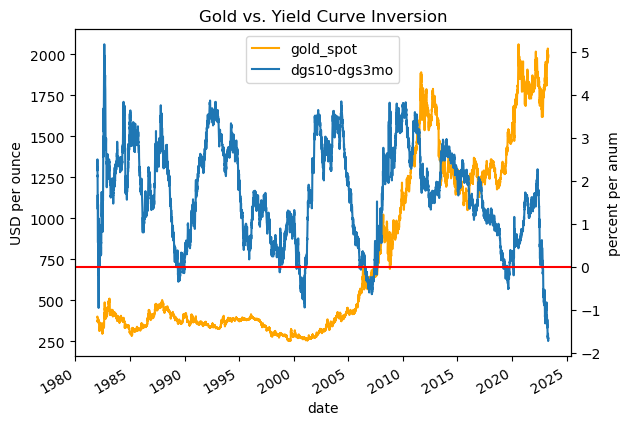

In [62]:
if __name__ == '__main__':
    print_correlations()
    recession_visual()